# 1. Setup and Load Data

## 1.1 Install Dependencies and Setup

In [1]:
# All the below tools are installed in the "tensorflow" env
#!pip install tensorflow opencv-python matplotlib

In [2]:
#!pip list

In [3]:
import tensorflow as tf
import os

In [4]:
gpus = tf.config.list_physical_devices('GPU')
cpus = tf.config.list_physical_devices('CPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
cpus

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## 1.2 Remove Doggy Images

In [7]:
import cv2
import imghdr
from matplotlib import pyplot as plt

/var/folders/cg/drwvcmcs4zb18rstmq029rkm0000gn/T/ipykernel_4091/3427753027.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [8]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']
data_dir = '/Users/abbazs/Projects/ML-Data-Science/Image Classification /images'

/Users/abbazs/Projects/ML-Data-Science/Image Classification /images/happy/smiling-faces.jpg


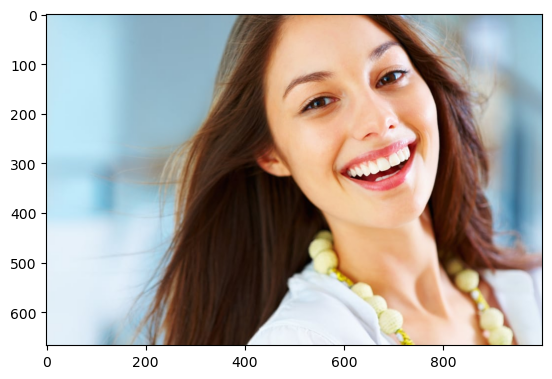

In [9]:
sample_img_name = os.listdir(os.path.join(data_dir, "happy"))[0]
sample_img_path = os.path.join(data_dir,"happy", sample_img_name)
print(sample_img_path)
# Image comes in BGR format
img_bgr = cv2.imread(sample_img_path)

# Convert image to RGB
img_rgb = plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
img_rgb

In [10]:
for image_folder in os.listdir(data_dir):
  if image_folder == ".DS_Store":
      continue
  for image in os.listdir(os.path.join(data_dir,image_folder)):
    image_path = os.path.join(data_dir,image_folder,image)
    try:
      img = cv2.imread(image_path)
      tip = imghdr.what(image_path)
      if tip not in image_exts:
        print("Image not in ext list {}".format(image_path))
        os.remove(image_path)
    except Exception as e:
      print("Issue with image {}".format(image_path))

## 1.3 Load Data

In [11]:
import numpy as np
from matplotlib import pyplot as plt

In [12]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 453 files belonging to 2 classes.


2024-03-17 15:27:09.590040: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-03-17 15:27:09.590062: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-03-17 15:27:09.590066: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-03-17 15:27:09.590097: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-17 15:27:09.590110: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
data_iterator = data.as_numpy_iterator()

In [14]:
#Re-run to get next batch of data
batch = data_iterator.next()

In [15]:
#Class 1 is sad
#Class 0 is happy
batch[0].shape

(32, 256, 256, 3)

In [16]:
batch[1]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 1], dtype=int32)

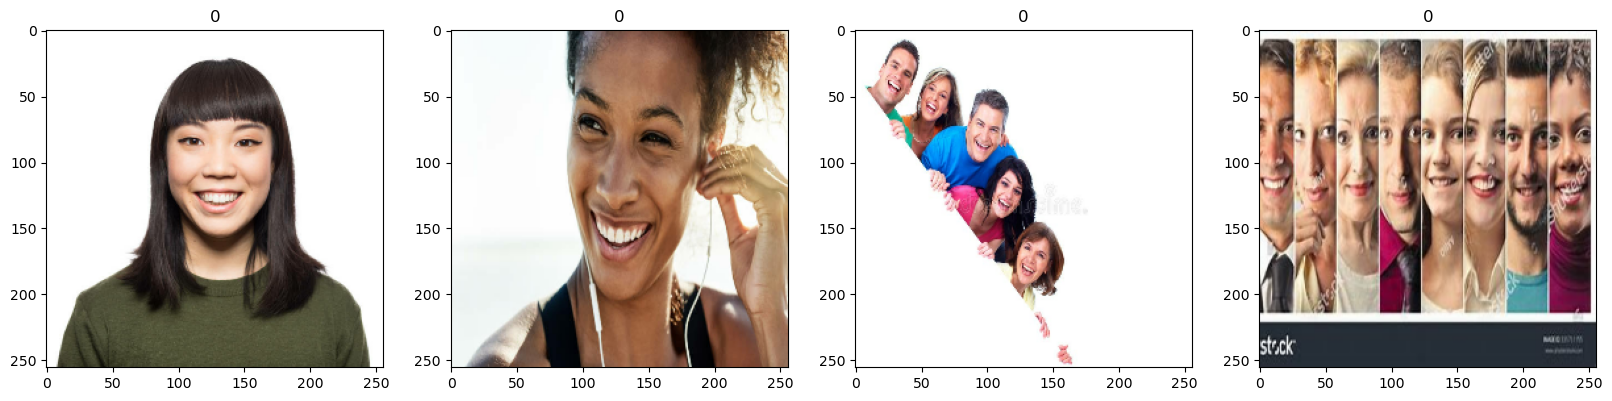

In [17]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

# 2. Preprocess Data
## 2.1 Scale Data

In [18]:
data = data.map( lambda x, y : (x/255, y))

In [19]:
scaled_iterator = data.as_numpy_iterator()

In [20]:
batch = scaled_iterator.next()

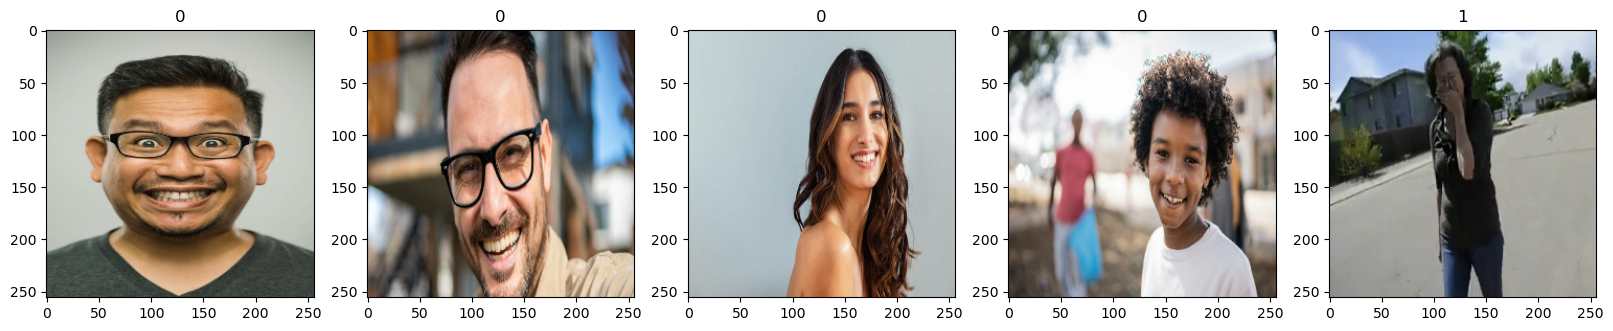

In [21]:
fig, ax = plt.subplots(ncols=5, figsize=(20,20))
for idx, img in enumerate(batch[0][:5]):
  ax[idx].imshow(img)
  ax[idx].title.set_text(batch[1][idx])

## 2.2 Split Data

In [22]:
len(data)

15

In [23]:
train_size = int(len(data) * .7)
val_size = int(len(data) * .2)
test_size = int(len(data) * .1) + 1

train_size, val_size,test_size

(10, 3, 2)

In [24]:
# Since our data is already shuffled, we are not going to shuffle the data here 

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

# 3. Deep Learning
## 3.1 Build Deep Learning Model

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [26]:
model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [27]:
model.compile('adam',loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

## 3.2 Train

In [29]:
logdir = 'logs'

In [30]:
tensorflow_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [31]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=tensorflow_callback)

Epoch 1/20


2024-03-17 15:27:11.281114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 2s 103ms/step - loss: 0.7379 - accuracy: 0.4781 - val_loss: 0.7240 - val_accuracy: 0.4375
Epoch 2/20
10/10 [==============================] - 1s 82ms/step - loss: 0.6796 - accuracy: 0.5750 - val_loss: 0.6774 - val_accuracy: 0.5833
Epoch 3/20
10/10 [==============================] - 1s 85ms/step - loss: 0.6863 - accuracy: 0.5063 - val_loss: 0.6824 - val_accuracy: 0.5000
Epoch 4/20
10/10 [==============================] - 1s 87ms/step - loss: 0.6731 - accuracy: 0.5469 - val_loss: 0.6653 - val_accuracy: 0.5000
Epoch 5/20
10/10 [==============================] - 1s 85ms/step - loss: 0.6302 - accuracy: 0.6031 - val_loss: 0.6648 - val_accuracy: 0.6146
Epoch 6/20
10/10 [==============================] - 1s 87ms/step - loss: 0.5793 - accuracy: 0.7063 - val_loss: 0.5195 - val_accuracy: 0.7396
Epoch 7/20
10/10 [==============================] - 1s 85ms/step - loss: 0.5039 - accuracy: 0.7594 - val_loss: 0.4949 - val_accuracy: 0.7500
Epoch 8/20
10/10 [=====

In [32]:
hist.history

{'loss': [0.7379222512245178,
  0.6795604228973389,
  0.6862735152244568,
  0.6731047630310059,
  0.6301671266555786,
  0.5792967081069946,
  0.5038942098617554,
  0.47129639983177185,
  0.3455830216407776,
  0.3189998269081116,
  0.20937147736549377,
  0.1278761625289917,
  0.08901545405387878,
  0.04279094934463501,
  0.033586930483579636,
  0.023435723036527634,
  0.014217302203178406,
  0.006269493605941534,
  0.008180358447134495,
  0.009252617135643959],
 'accuracy': [0.4781250059604645,
  0.574999988079071,
  0.5062500238418579,
  0.546875,
  0.6031249761581421,
  0.706250011920929,
  0.7593749761581421,
  0.78125,
  0.846875011920929,
  0.871874988079071,
  0.934374988079071,
  0.965624988079071,
  0.9781249761581421,
  0.996874988079071,
  0.9906250238418579,
  0.996874988079071,
  1.0,
  1.0,
  0.996874988079071,
  1.0],
 'val_loss': [0.723966121673584,
  0.6774018406867981,
  0.6824157238006592,
  0.6652852892875671,
  0.6647956371307373,
  0.5195062756538391,
  0.4949221312

## 3.3 Plot Performance

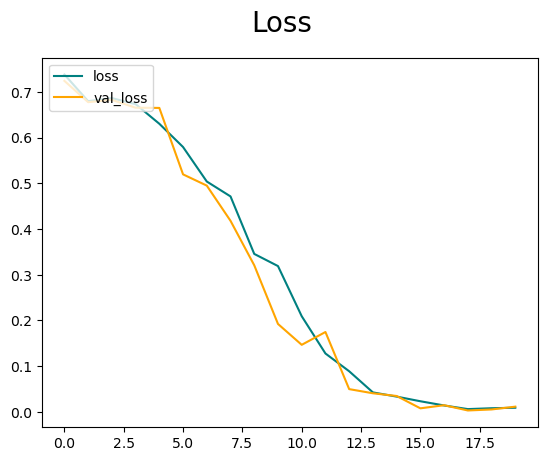

In [33]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

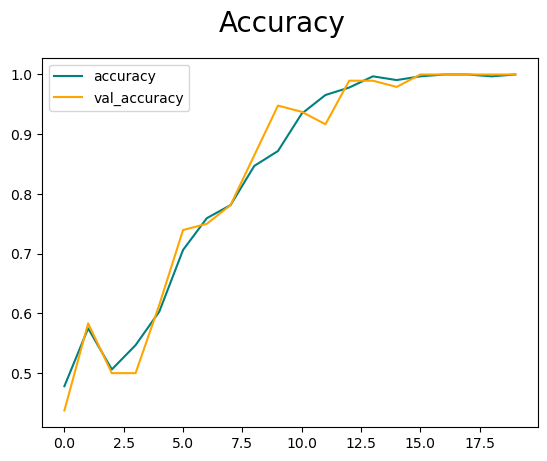

In [34]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

# 4. Evaluate Performance
## 4.1 Evaluate

In [35]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [36]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [37]:
for batch in test.as_numpy_iterator():
    x, y = batch
    yhat = model.predict(x)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 59ms/step


In [38]:
print(f'Precision : {pre.result().numpy()}, Recall : {re.result().numpy()}, Accuracy : {acc.result().numpy()}')

Precision : 1.0, Recall : 1.0, Accuracy : 1.0


## 4.2 Test

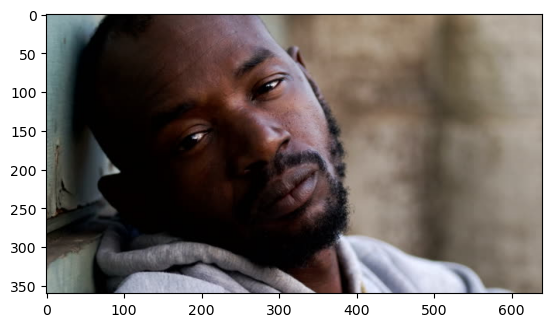

In [39]:
# Testing with a random image from the internet

sample_img_1_path = os.path.join('/Users/abbazs/Projects/ML-Data-Science/Image Classification ', "random-image_1.jpeg")
sample_img_2_path = os.path.join('/Users/abbazs/Projects/ML-Data-Science/Image Classification ', "random-image_2.jpeg")

# Image comes in BGR format
img_bgr_1 = cv2.imread(sample_img_1_path)
img_bgr_2 = cv2.imread(sample_img_2_path)

# Convert image to RGB
img_rgb_1 = plt.imshow(cv2.cvtColor(img_bgr_1, cv2.COLOR_BGR2RGB))


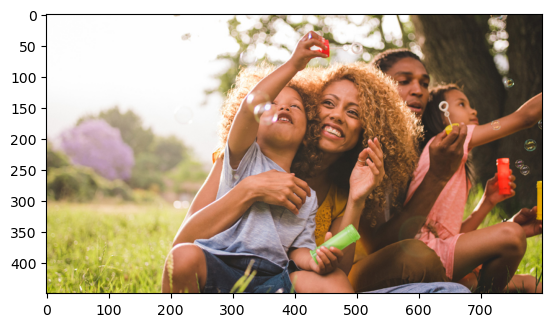

In [40]:
img_rgb_2 = plt.imshow(cv2.cvtColor(img_bgr_2, cv2.COLOR_BGR2RGB))

In [41]:
random_test_images = [tf.image.resize(img_bgr_1, (256,256)), tf.image.resize(img_bgr_2, (256,256))]
random_test_y = [1,0]
random_test_yhat = []
for image in random_test_images:
    # The reason for a different code below is due to the fact that our images are just arrays but we need to feed the function batches
    yhat = model.predict(np.expand_dims(image/255, 0))
    random_test_yhat.append(yhat)

1/1 [==============================] - 0s 12ms/step


In [42]:
print(f'Image 1 Actual Type : {random_test_y[0]}, Image 1 Predicted Type {random_test_yhat[0][0][0]}')
print(f'Image 2 Actual Type : {random_test_y[1]}, Image 2 Predicted Type {random_test_yhat[1][0][0]}')

Image 1 Actual Type : 1, Image 1 Predicted Type 0.9999613761901855
Image 2 Actual Type : 0, Image 2 Predicted Type 3.712243415066041e-05


# 5. Save Model
## 5.1 Save the model

In [43]:
from tensorflow.keras.models import load_model

In [44]:
model.save(os.path.join('models', 'happysadmodel.h5'))

/Users/abbazs/miniforge3/envs/tensorflow/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 5.2 Load Model

In [45]:
new_model = load_model(os.path.join('models', 'happysadmodel.h5'))

In [46]:
new_model.predict(np.expand_dims(tf.image.resize(img_bgr_2, (256,256))/255, 0))

1/1 [==============================] - 0s 53ms/step


array([[3.7122434e-05]], dtype=float32)